In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import quandl
from pathlib import Path
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf
from datetime import date
import numpy as np
from sklearn import metrics, svm
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import utils
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Needed for decision tree visualization
import pydotplus
from IPython.display import Image

yf.pdr_override()

In [3]:
#setting today's date
today = date.today()

In [49]:
# getting the data

# 10 Year note
us_treasury = pd.read_csv(r"csvs/10 yr treasury csv.csv").set_index("Date")
#us_treasury = us_treasury['10 YR'].to_frame()
us_treasury

# gold prices
gold = pd.read_csv(r"csvs/gold prices csv.csv").set_index("Date")
#gold = gold['USD (AM)']
#gold = gold.to_frame()
gold

# emerging markets high yield corporate bond index yield
emerging_markets_high_yield_corporate_bond_index_yield = pd.read_csv(r"csvs/Emerging Markets HYCBIY Value csv.csv").set_index("DATE")
emerging_markets_high_yield_corporate_bond_index_yield

# s&p 500 inflation adjusted
sp_500_inflation_adjusted = pd.read_csv(r"csvs/Emerging Markets HYCBIY Value csv.csv").set_index("DATE")
sp_500_inflation_adjusted

# personal consumption expenditures
personal_consumption_expenditures = pd.read_csv("csvs/personal consumption expenditures csv.csv").set_index("Date")

In [50]:
# Dow Jones 
dji = pd.read_csv(r"csvs/Download Data - INDEX_US_DOW JONES GLOBAL_DJIA_3.csv",infer_datetime_format=True,parse_dates=True).set_index("Date")
# setting dow to be our test
y = dji["Close"].iloc[::-1].to_frame()

In [51]:
#personal_consumption_expenditures.rename(columns={"Value":"PCE Value"},inplace=True)
#gold.rename(columns={"Value":"Gold Value"},inplace=True)
#sp_500_inflation_adjusted.rename(columns={'Value':'SPY Value'},inplace=True)
#emerging_markets_high_yield_corporate_bond_index_yield.rename(columns={'BAMLEMHBHYCRPIEY':'Emerging Markets HYCBIY Value'},inplace=True)

In [52]:
# aggregating data into dataframe
X = pd.concat([us_treasury,gold,emerging_markets_high_yield_corporate_bond_index_yield,
                  sp_500_inflation_adjusted,personal_consumption_expenditures],axis = 'columns', join = 'inner')
X

,10 YR,USD (AM),Emerging Markets HYCBIY Value,Emerging Markets HYCBIY Value,PCE Value
2/1/99,4.75,287.10,15.95,15.95,6101.8
3/1/99,5.40,287.05,15.49,15.49,6132.9
4/1/99,5.27,280.50,14.30,14.30,6196.2
6/1/99,5.78,265.50,13.91,13.91,6254.0
7/1/99,5.85,263.00,13.53,13.53,6281.5
...,...,...,...,...,...
10/1/20,0.68,1895.55,7.15,7.15,14627.1
12/1/20,0.92,1796.20,6.05,6.05,14451.1
2/1/21,1.09,1857.80,5.71,5.71,14774.0
3/1/21,1.45,1746.95,5.73,5.73,15515.3


In [55]:
# reworking dow data to fit model
y = y.pct_change().dropna()
dji_reworked = pd.concat([X,y], axis='columns', join = 'inner')
dji_reworked = dji_reworked['Close'].to_frame()
y = dji_reworked

TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)

ValueError: Found input variables with inconsistent numbers of samples: [167, 495]

In [8]:
X_train.sort_index()

,10 YR,USD (AM),Emerging Markets HYCBIY Value,SPY Value,PCE Value
1999-02-01,4.75,287.10,15.95,2039.96,6101.8
1999-03-01,5.40,287.05,15.49,2091.01,6132.9
1999-06-01,5.78,265.50,13.91,2142.14,6254.0
1999-07-01,5.85,263.00,13.53,2230.09,6281.5
1999-09-01,5.99,255.45,13.65,2113.43,6378.8
...,...,...,...,...,...
2020-10-01,0.68,1895.55,7.15,3534.33,14627.1
2020-12-01,0.92,1796.20,6.05,3819.03,14451.1
2021-02-01,1.09,1857.80,5.71,3974.70,14774.0
2021-03-01,1.45,1746.95,5.73,3974.26,15515.3


In [21]:
lab_enc = preprocessing.LabelEncoder()
y_train_encoded = lab_enc.fit_transform(y_train)
y_test_encoded = lab_enc.fit_transform(y_test)
y_train_encoded

C:\Users\Sebs1\anaconda3\envs\dev\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


array([  3,  22,  24,  42,  93,  85,  49,  71, 101,  63, 102,  39,   9,
        31,  30,  35,  92,  94,  69,  99, 110,  36,   7,  95,  32,  81,
        96,   6,  10,  12,   4, 109,  60,  41,  46,  82, 107,  23,   0,
        14,  80,   2,  57,  68, 104,  73,  72,  83,  89,  87,  56,  11,
        29,  97,  98,  76, 106,  13,  15, 103,  53,  70,  84,   8,  74,
        62,  61, 108,  91,  58,  64,  48,  26,  43,  19,  28,  86,  55,
        17,  54,  67,  50,  27,  79,  21,  52,  38,  34,  77,  78,  37,
        44,   1,  47,  88,  51,  40, 100,  25,  75,  20,  59, 105,  45,
        66,  33,  18,  90,  16,  65,   5], dtype=int64)

In [22]:
# Logistic Regression Model
classifier = LogisticRegression(solver='lbfgs', random_state=1)
classifier.fit(X_train, y_train_encoded)
print(f"Training Data Score: {classifier.score(X_train, y_train_encoded)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test_encoded)}")

predictions = classifier.predict(X_test)
pd.DataFrame({"Prediction": predictions, "Actual": y_test_encoded})

Training Data Score: 0.8558558558558559
Testing Data Score: 0.0


C:\Users\Sebs1\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Prediction,Actual
0,25,30
1,84,7
2,6,3
3,77,10
4,75,18
5,3,49
6,75,45
7,98,37
8,75,32
9,84,28


In [23]:
# Creating Scalar
scaler = StandardScaler()

In [24]:
# Fitting the training data to the model
X_scaler = scaler.fit(X_train)

# Scaling the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Fitting the decision tree
model = tree.DecisionTreeClassifier()
model = model.fit(X_train_scaled, y_train_encoded)

# Making predictions
predictions = model.predict(X_test_scaled)

In [25]:
cm = confusion_matrix(y_test_encoded, predictions)
cm_df = pd.DataFrame(cm)

# Calculating the accuracy score
acc_score = accuracy_score(y_test_encoded, predictions)

# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test_encoded, predictions))

Confusion Matrix


,0,1,2,3,4,5,6,7,8,9,...,67,68,69,70,71,72,73,74,75,76
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Accuracy Score : 0.0
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       1.0
           2       0.00      0.00      0.00       1.0
           3       0.00      0.00      0.00       1.0
           4       0.00      0.00      0.00       1.0
           5       0.00      0.00      0.00       1.0
           6       0.00      0.00      0.00       1.0
           7       0.00      0.00      0.00       1.0
           8       0.00      0.00      0.00       1.0
           9       0.00      0.00      0.00       1.0
          10       0.00      0.00      0.00       1.0
          11       0.00      0.00      0.00       1.0
          12       0.00      0.00      0.00       1.0
          13       0.00      0.00      0.00       1.0
          14       0.00      0.00      0.00       1.0
          15       0.00      0.00      0.00       1.0
          16       0.00      0.00     

C:\Users\Sebs1\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sebs1\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
cm

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

<AxesSubplot:>

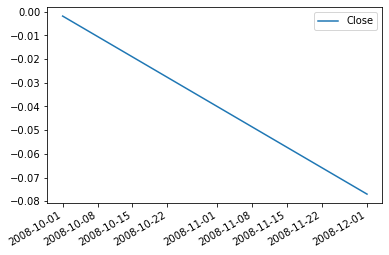

In [27]:
dji_reworked['10-01-2008':'12-01-2008'].plot()

<AxesSubplot:>

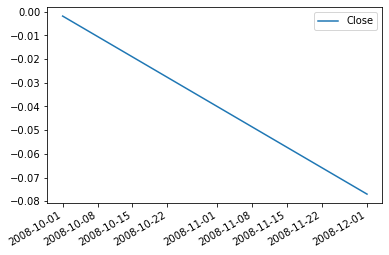

In [28]:
y['10-01-2008':'12-01-2008'].plot()

<AxesSubplot:xlabel='Date'>

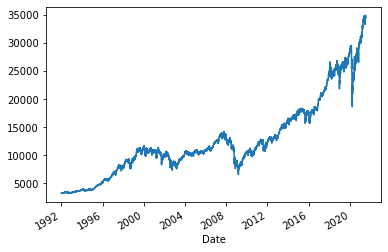

In [29]:
dji['Close'].plot()

In [30]:
us_treasury.to_csv("csvs/us_treasury.csv")
gold.to_csv('csvs/gold.csv')
emerging_markets_high_yield_corporate_bond_index_yield.to_csv('csvs/emerging_markets_high_yield_corporate_bond_index_yield.csv')
sp_500_inflation_adjusted.to_csv("csvs/sp_500_inflation_adjusted.csv")
personal_consumption_expenditures.to_csv("csvs/personal_consumption_expenditures.csv")